# Latent Birds: _A bird's-eye view exploration of the latent space_
### Juan Alonso (jalons19@student.aau.dk) SMC07

## 1. Enviroment setup

### Imports

In [1]:
%load_ext autoreload
%autoreload 1

import pickle
import time
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import librosa as librosa
import librosa.display as display

import IPython.display as ipd
from IPython.display import clear_output

import numpy as np
from numpy import savetxt

import matplotlib.pyplot as plt
%matplotlib inline 

from keras.layers import Input, Dense, Lambda, Flatten, Reshape, BatchNormalization
from keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, Dropout, SpatialDropout2D
from keras.layers import LeakyReLU
from keras.models import Model, load_model, model_from_json
from keras.losses import mse
from keras import backend as K
from keras import optimizers
from keras.callbacks import ModelCheckpoint

%aimport SMCutils
su = SMCutils

Using TensorFlow backend.


### Global variables

In [2]:
sr         = 22050  #sampling rate
fmin       = 20     #min freq 
fmax       = sr / 2 #max freq
n_fft      = 4096   #number of samples
hop_length = 690    #(columns) - so we can get 128 frames 
n_frames   = 128
n_mels     = 128    #(rows) - With this, we get nice 128 x 128 spectrograms 

### Load the spectrograms

In [3]:
folder    = 'spectrograms/'
# file_list = su.get_file_list(folder, extension='png')
# 
# mel_spectrogram_array = su.get_spectrogram_array(file_list, 
#                                                  n_mels, n_frames, 
#                                                  folder, 'birds_cornell', 
#                                                  from_file_list=True)
# np.save('spectrogram_array.npy', mel_spectrogram_array)

In [4]:
mel_spectrogram_array = np.load('spectrogram_array.npy')

### Split dataset into training and test

In [5]:
x_train, x_test = su.split_dataset(mel_spectrogram_array, percentage_train=0.80, shuffle=True)

print(len(x_train), "spectrograms for training,", len(x_test), "for testing")

7256 spectrograms for training, 1815 for testing


## 2. Network architecture

### NN Hyperparameters

In [6]:
weights_name     = 'latentbirds_003.h5'

In [7]:
latent_space_dim = 512
batch_size       = 128
epochs           = 1500
learning_rate    = 0.00025
kernel           = (3,3)  
act_layer        = LeakyReLU()
optimizer        = optimizers.adam(lr=learning_rate)
loss             = 'mse'
act_last_layer   = 'sigmoid'

### VAE helpers

In [8]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

### Encoder

In [9]:
input_encoder = Input(shape=(n_mels*n_frames,), name='input_encoder')

encoder     = Reshape((n_mels, n_frames,-1))(input_encoder)

encoder     = Conv2D(32, kernel, activation=act_layer, padding='same')(encoder)
encoder     = MaxPooling2D((2, 2), padding='same')(encoder)
# encoder     = SpatialDropout2D(0.1)(encoder)

encoder     = Conv2D(64, kernel, activation=act_layer, padding='same')(encoder)
encoder     = MaxPooling2D((2, 2), padding='same')(encoder)
# encoder     = SpatialDropout2D(0.1)(encoder)

encoder     = Conv2D(128, kernel, activation=act_layer, padding='same')(encoder)
encoder     = MaxPooling2D((2, 2), padding='same')(encoder)
# encoder     = SpatialDropout2D(0.1)(encoder)

encoder     = Conv2D(256, kernel, activation=act_layer, padding='same')(encoder)
encoder     = MaxPooling2D((2, 2), padding='same')(encoder)
# encoder     = SpatialDropout2D(0.1)(encoder)

encoder     = Conv2D(512, kernel, activation=act_layer, padding='same')(encoder)
encoder     = MaxPooling2D((2, 2), padding='same')(encoder)
# encoder     = SpatialDropout2D(0.1)(encoder)

encoder     = Conv2D(1024, kernel, activation=act_layer, padding='same')(encoder)
encoder     = MaxPooling2D((4, 4), padding='same')(encoder)

encoder     = Flatten()(encoder)

#VAE
z_mean      = Dense(latent_space_dim, name='z_mean')(encoder)
z_log_var   = Dense(latent_space_dim, name='z_log_var')(encoder)  
z           = Lambda(sampling, output_shape=(latent_space_dim,), name='z')([z_mean, z_log_var])

encoder_vae = Model(input_encoder, [z_mean, z_log_var, z], name='encoder_vae')
encoder_vae.summary()

Model: "encoder_vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_encoder (InputLayer)      (None, 16384)        0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 128, 128, 1)  0           input_encoder[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 320         reshape_1[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 32)   0           conv2d_1[0][0]                   
________________________________________________________________________________________

/home/jalons19/miniconda3/envs/tfgpu/lib/python3.7/site-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


### Decoder

In [10]:
input_latent = Input(shape=(latent_space_dim,), name='z_sampling')

decoder = Dense(n_mels*n_frames//32, activation=act_layer)(input_latent)
# decoder = Dropout(0.1)(decoder)

decoder = Dense(n_mels*n_frames//8, activation=act_layer)(decoder)
# decoder = Dropout(0.1)(decoder)

decoder = Dense(n_mels*n_frames//4, activation=act_layer)(decoder)
# decoder = Dropout(0.1)(decoder)

decoder = Dense(n_mels*n_frames, activation=act_last_layer)(decoder)

decoder_vae = Model(input_latent, decoder, name='decoder_vae')
decoder_vae.summary()

Model: "decoder_vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              1050624   
_________________________________________________________________
dense_3 (Dense)              (None, 4096)              8392704   
_________________________________________________________________
dense_4 (Dense)              (None, 16384)             67125248  
Total params: 76,831,232
Trainable params: 76,831,232
Non-trainable params: 0
_________________________________________________________________


### Full model

In [11]:
output_decoder = decoder_vae(encoder_vae(input_encoder)[2])

full_vae = Model(input_encoder,output_decoder, name='full_vae')

reconstruction_loss  = mse(input_encoder, output_decoder)
reconstruction_loss *= (n_mels*n_frames)

kl_loss  = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss  = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

full_vae.add_loss(vae_loss)
full_vae.compile(optimizer=optimizer)
full_vae.summary()

Model: "full_vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_encoder (InputLayer)   (None, 16384)             0         
_________________________________________________________________
encoder_vae (Model)          [(None, 512), (None, 512) 7337216   
_________________________________________________________________
decoder_vae (Model)          (None, 16384)             76831232  
Total params: 84,168,448
Trainable params: 84,168,448
Non-trainable params: 0
_________________________________________________________________


/home/jalons19/miniconda3/envs/tfgpu/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder_vae missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder_vae.
  'be expecting any data to be passed to {0}.'.format(name))


In [12]:
raise SystemExit("Stop right there!")

SystemExit: Stop right there!

/home/jalons19/miniconda3/envs/tfgpu/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Training

In [ ]:
# epochs = 410
# full_vae.load_weights('incremental/best_' + weights_name)
# full_vae.load_weights('weights/' + weights_name)

In [ ]:
start_time = time.time()

checkpoint = ModelCheckpoint('incremental/best_'+weights_name, monitor='loss', verbose=1, 
                              save_best_only=True, mode='auto', period=15, save_weights_only=True)

history = full_vae.fit(x_train,
               epochs = 5,
               batch_size = batch_size,
               validation_data=(x_test, None),
               verbose=1)

history = full_vae.fit(x_train,
               epochs = epochs-5,
               batch_size = batch_size,
               validation_data=(x_test, None),
               verbose=1,
               callbacks=[checkpoint])

print('Done in {0:.2f} seconds'.format((time.time() - start_time)))

### Loss chart

In [ ]:
# with open('dictionaries/' + weights_name[:-3] + '_history.dict', 'wb') as file_handler:
#         pickle.dump(history.history, file_handler)

In [ ]:
history = pickle.load(open('dictionaries/' + weights_name[:-3] + '_history.dict', "rb"))

In [ ]:
plt.figure(figsize=[15,6])

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

axes = plt.gca()
axes.set_ylim([0,300])
axes.set_yticks(np.arange(0, 301, 25))
# axes.set_xticks(np.arange(0, 1501, 100))
axes.grid(which='major', alpha=0.5, axis='y')
# axes.grid(which='major', alpha=0.25, axis='x')

plt.savefig(weights_name[:-3] + '_loss.png',bbox_inches='tight', pad_inches=0)

### Save the weights

In [ ]:
#full_vae.save_weights('weights/' + weights_name)

### Load the weights

In [12]:
full_vae.load_weights('weights/' + weights_name)
#full_vae.load_weights('incremental/best_' + weights_name)

print("Train loss",full_vae.evaluate(x_train))
print("Test loss",full_vae.evaluate(x_test))

7256/7256 [==============================] - 6s 816us/step
Train loss 97.24128342095389
1815/1815 [==============================] - 1s 660us/step
Test loss 99.30511687727999


### Plot two random dimensions of the z mean vector

In [13]:
zm_train, zlv_train, zs_train = encoder_vae.predict(x_train, batch_size = batch_size)
zm_test,  zlv_test,  zs_test  = encoder_vae.predict(x_test,  batch_size = batch_size)

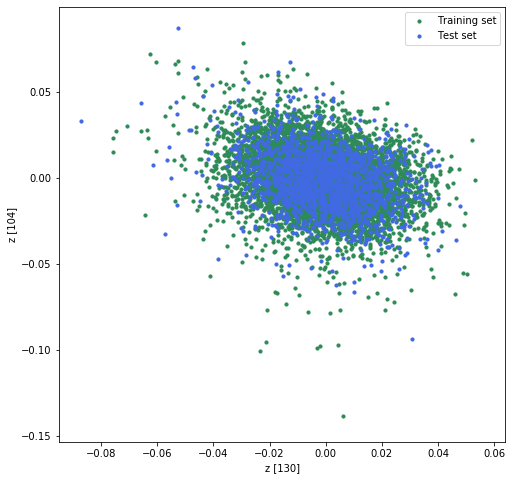

In [14]:
plt.figure(figsize=(8,8))

d1 = np.random.randint(0,latent_space_dim) 
d2 = np.random.randint(0,latent_space_dim) 
#d1 = 193
#d2 = 384

plt.scatter(zm_train[:, d1], zm_train[:, d2],c='seagreen',s=10, label="Training set")
plt.scatter(zm_test[:, d1], zm_test[:, d2], c='royalblue', s=10, label="Test set")
plt.xlabel("z [{}]".format(d1))
plt.ylabel("z [{}]".format(d2))
plt.legend()

## 4. Using the NN

### 4.1 Sanity check - Recover an existing song

In [14]:
#choose a dataset
dataset = x_train

#choose a random element from the dataset
# element = np.random.randint(0,len(dataset))
element = 4080
print("Reconstructing song no.", element)

#feed the spectrogram into the NN and get it back
decoded_data = full_vae.predict(np.reshape(dataset[element],(1,-1)))

#reconstruct both spectrograms and audio
mel_orig, y_orig = su.spectrogram_to_audio(dataset[element],n_mels,n_frames, sr, n_fft, hop_length, fmin, fmax)
mel_rec, y_rec = su.spectrogram_to_audio(decoded_data,n_mels,n_frames, sr, n_fft, hop_length, fmin, fmax)

Reconstructing song no. 4080


### Compare results

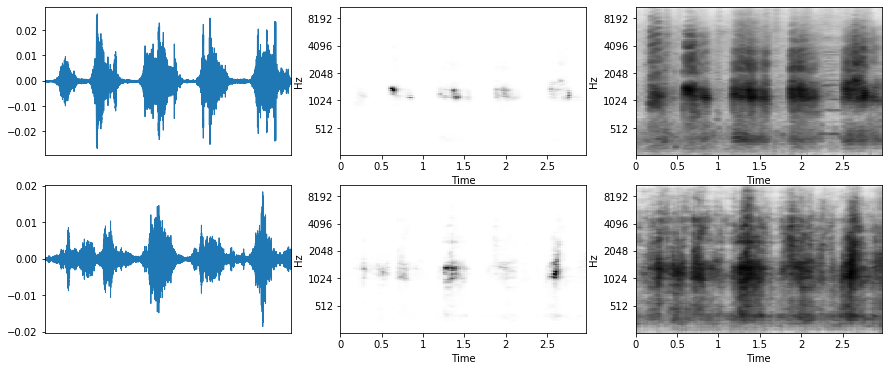

In [15]:
plt.figure(figsize=[15,6])

fig = plt.subplot(2, 3, 1)
librosa.display.waveplot(y_orig);
fig.axes.get_xaxis().set_visible(False)

plt.subplot(2, 3, 2)
librosa.display.specshow(mel_orig, x_axis='time', y_axis='mel', 
                         cmap='binary', fmin=fmin, fmax=fmax);
#plt.colorbar(orientation='horizontal')

plt.subplot(2, 3, 3)
librosa.display.specshow(librosa.power_to_db(mel_orig), x_axis='time', y_axis='mel', 
                         cmap='binary', fmin=fmin, fmax=fmax);
#plt.colorbar(orientation='horizontal')

fig = plt.subplot(2, 3, 4)
librosa.display.waveplot(y_rec);
fig.axes.get_xaxis().set_visible(False)

plt.subplot(2, 3, 5)
librosa.display.specshow(mel_rec, x_axis='time', y_axis='mel', 
                         cmap='binary',fmin=fmin, fmax=fmax);
#plt.colorbar(orientation='horizontal')

plt.subplot(2, 3, 6)
librosa.display.specshow(librosa.power_to_db(mel_rec), x_axis='time', y_axis='mel', 
                         cmap='binary',fmin=fmin, fmax=fmax);
#plt.colorbar(orientation='horizontal')

### Frequency spread

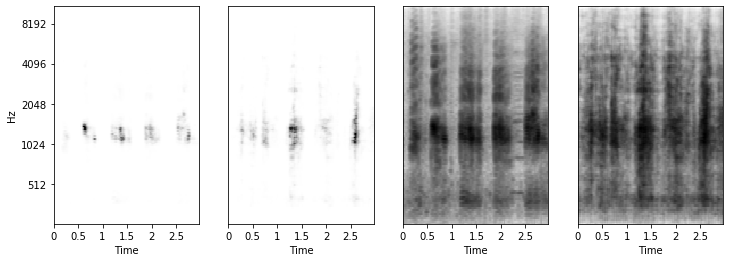

In [19]:
plt.figure(figsize=[12,4])

plt.subplot(1, 4, 1)
librosa.display.specshow(mel_orig, x_axis='time', y_axis='mel', 
                         cmap='binary', fmin=fmin, fmax=fmax);
#plt.colorbar(orientation='horizontal')

fig = plt.subplot(1, 4, 2)
librosa.display.specshow(mel_rec, x_axis='time', y_axis='mel', 
                         cmap='binary',fmin=fmin, fmax=fmax);
fig.axes.get_yaxis().set_visible(False)

fig = plt.subplot(1, 4, 3)
librosa.display.specshow(librosa.power_to_db(mel_orig), x_axis='time', y_axis='mel', 
                         cmap='binary', fmin=fmin, fmax=fmax);
#plt.colorbar(orientation='horizontal')
fig.axes.get_yaxis().set_visible(False)

fig = plt.subplot(1, 4, 4)
librosa.display.specshow(librosa.power_to_db(mel_rec), x_axis='time', y_axis='mel', 
                         cmap='binary',fmin=fmin, fmax=fmax);
#plt.colorbar(orientation='horizontal')
fig.axes.get_yaxis().set_visible(False)


### Original song

In [20]:
ipd.Audio(y_orig, rate=sr)
#librosa.output.write_wav('{}_original_{}.wav'.format(weights_name[:-3],element), y_orig, sr)

### Reconstructed song

In [21]:
ipd.Audio(y_rec, rate=sr)
#librosa.output.write_wav('{}_reconstructed_{}.wav'.format(weights_name[:-3],element), y_rec, sr)

### Visualize the activations of the first convolutional layer

In [22]:
layer_outputs = [layer.output for layer in encoder_vae.layers[:3]] 
activation_model = Model(inputs=input_encoder, outputs=layer_outputs)

In [23]:
activations = activation_model.predict(np.reshape(dataset[element],(1,-1))) 

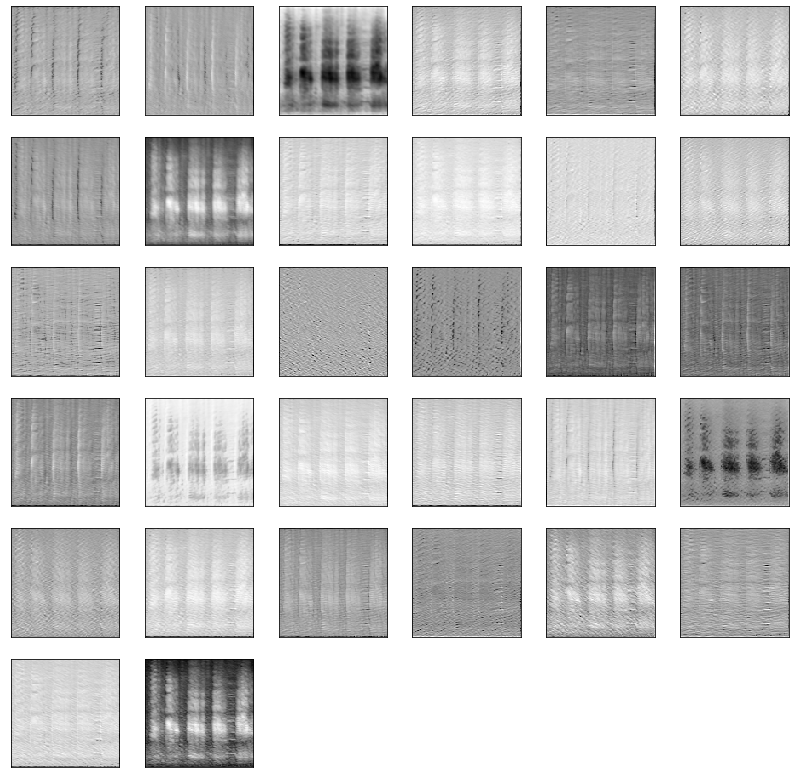

In [24]:
fig = plt.figure(figsize=[14,14])
for f in range(0,32):
    plt.subplot(6, 6, f+1)
    fig = plt.imshow(activations[2][0,:,:,f], cmap='binary', origin='lower')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
plt.savefig('activations/' + weights_name[:-3] + '_activations.png',bbox_inches='tight')

### 4.2 Generate a new song

In [40]:
#sample latent space
zs = np.random.normal(size=(1,latent_space_dim))

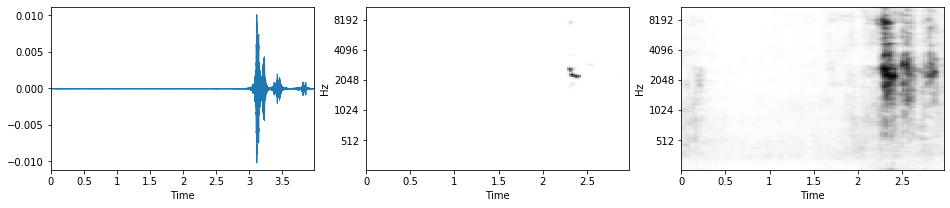

In [41]:
#decode the vector
decoded_data = decoder_vae.predict(zs)

#reconstruct the data
mel_rec, y_rec = su.spectrogram_to_audio(decoded_data,n_mels,n_frames, sr, n_fft, hop_length, fmin, fmax)

#plot the results
plt.figure(figsize=[16,3])

plt.subplot(1, 3, 2)
librosa.display.specshow(mel_rec, x_axis='time', y_axis='mel', 
                         cmap='binary', fmin=fmin, fmax=fmax);

plt.subplot(1, 3, 3)
librosa.display.specshow(librosa.power_to_db(mel_rec), x_axis='time', y_axis='mel', 
                         cmap='binary', fmin=fmin, fmax=fmax);

plt.subplot(1, 3, 1)
librosa.display.waveplot(y_rec);

### Play song

In [42]:
# librosa.output.write_wav('new_song.wav', y_rec, sr)
ipd.Audio(y_rec, rate=sr)

In [43]:
raise SystemExit("Stop right there!")

SystemExit: Stop right there!

### 4.3 Song interpolation

Interpolate from 6058 to 683
Generating step 0
Generating step 1
Generating step 2
Generating step 3
Generating step 4
Generating step 5
Generating step 6


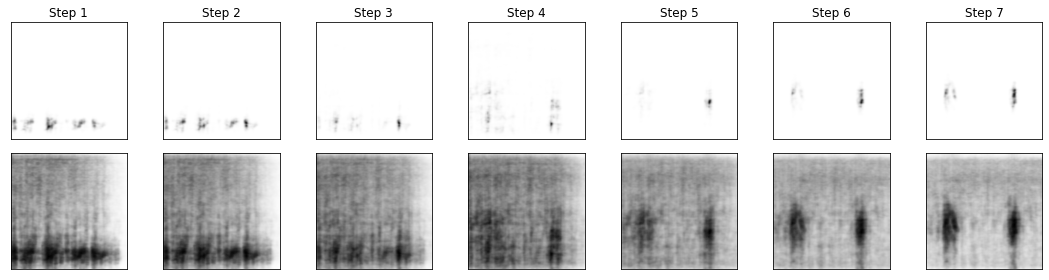

In [47]:
#choose a dataset
dataset = x_train

elt_from = np.random.randint(0,len(dataset))
elt_to = np.random.randint(0,len(dataset))

print("Interpolate from {} to {}".format(elt_from, elt_to))

_,_,zs_from = encoder_vae.predict(np.reshape(dataset[elt_from],(1,-1)))
_,_,zs_to = encoder_vae.predict(np.reshape(dataset[elt_to],(1,-1)))

total_figures = 7

plt.figure(figsize=(15, 4))

for x in range(0,total_figures):
        
    print("Generating step", x)
    #clear_output(wait=True)
    
    pan = x / (total_figures-1)
    zs = zs_from * (1-pan) + zs_to * pan
    
    decoded_data = decoder_vae.predict(zs)
    decoded_data = np.reshape(decoded_data,(n_mels,-1))
    mel_rec, y_rec = su.spectrogram_to_audio(decoded_data,n_mels,n_frames, sr, n_fft, hop_length, fmin, fmax)
    librosa.output.write_wav('twitter_data/interp_{:04d}_{:04d}_{:02d}.wav'.format(elt_from, elt_to, x), y_rec, sr, norm=True)

    plt.subplot(2,total_figures,x + 1)
    plt.xticks([])
    plt.yticks([])
    plt.title("Step {}".format(x+1), size=12)
    plt.imshow(mel_rec, interpolation = "bicubic", cmap = "binary")
    
    plt.subplot(2,total_figures,total_figures + x + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(librosa.power_to_db(mel_rec), interpolation = "bicubic", cmap = "binary")

plt.tight_layout()

# Generate data for Twitter bot - New songs

In [ ]:
raise SystemExit("Stop right there!")

In [ ]:
start_time = time.time()
for f in range(1,201):
    
    print("Generating song", f)
    clear_output(wait=True)
    
    zs = np.random.normal(size=(1,latent_space_dim))

    decoded_data = decoder_vae.predict(zs)
    mel_rec, y_rec = su.spectrogram_to_audio(decoded_data,n_mels,n_frames, sr, n_fft, hop_length, fmin, fmax)

    filename = 'twitter_data/bird_{:05d}'.format(np.random.randint(0,99999))

    _fig_ = plt.figure(figsize=(12, 6))  
    
    spectrogram = plt.subplot(111)
    spectrogram.set_axis_off()
    librosa.display.specshow(librosa.power_to_db(mel_rec), x_axis='time', y_axis='mel', 
                          fmin=fmin, fmax=fmax, cmap='viridis');
    wave = _fig_.add_axes([0.125, 0.25, 0.775, 0.5])
    wave.set_axis_off()
    librosa.display.waveplot(y_rec, color='white');

    plt.savefig(filename + '.png', bbox_inches='tight', pad_inches=0)
    plt.close()
    
    _fig_ = plt.figure(figsize=(12, 6))  
    spectrogram = plt.subplot(111)
    spectrogram.set_axis_off()
    librosa.display.specshow(mel_rec, x_axis='time', y_axis='mel', 
                          fmin=fmin, fmax=fmax, cmap='binary');
    plt.close()

    bw = plt.subplot(111)
    bw.set_axis_off()
    plt.imshow(mel_rec, interpolation = "bicubic", cmap = "binary", clim=(np.amax(mel_rec)/40,np.amax(mel_rec)/20), origin='lower')
    plt.savefig(filename + '_bw.png', cmap='binary', bbox_inches='tight', pad_inches=0)
    plt.close()
    
    librosa.output.write_wav(filename + '.wav', y_rec, sr)
    
print('Done in {0:.2f} seconds'.format((time.time() - start_time)))

# Generate data for Twitter bot - Interpolated songs

In [ ]:
start_time = time.time()
for f in range(1,201):
    
    elt_from = np.random.randint(0,len(dataset))
    elt_to = np.random.randint(0,len(dataset))

    print("Generating song {}: {}-{}".format(f, elt_from, elt_to))
    clear_output(wait=True)
    
    _,_,zs_from = encoder_vae.predict(np.reshape(dataset[elt_from],(1,-1)))
    _,_,zs_to = encoder_vae.predict(np.reshape(dataset[elt_to],(1,-1)))
    
    pan = 0.5
    zs = zs_from * (1-pan) + zs_to * pan

    decoded_data = decoder_vae.predict(zs)
    mel_rec, y_rec = su.spectrogram_to_audio(decoded_data,n_mels,n_frames, sr, n_fft, hop_length, fmin, fmax)

    filename = 'twitter_data/inter_{:05d}_{:05d}'.format(elt_from, elt_to)

    _fig_ = plt.figure(figsize=(12, 6))  
    
    spectrogram = plt.subplot(111)
    spectrogram.set_axis_off()
    librosa.display.specshow(librosa.power_to_db(mel_rec), x_axis='time', y_axis='mel', 
                          fmin=fmin, fmax=fmax, cmap='viridis');
    wave = _fig_.add_axes([0.125, 0.25, 0.775, 0.5])
    wave.set_axis_off()
    librosa.display.waveplot(y_rec, color='white');

    plt.savefig(filename + '.png', bbox_inches='tight', pad_inches=0)
    plt.close()
    
    bw = plt.subplot(111)
    bw.set_axis_off()
    plt.imshow(mel_rec, interpolation = "bicubic", cmap = "binary", clim=(np.amax(mel_rec)/40,np.amax(mel_rec)/20), origin='lower')
    plt.savefig(filename + '_bw.png', cmap='binary', bbox_inches='tight', pad_inches=0)
    plt.close()    
    
    librosa.output.write_wav(filename + '.wav', y_rec, sr)
    
print('Done in {0:.2f} seconds'.format((time.time() - start_time)))

In [ ]:
import zipfile
zipf = zipfile.ZipFile('twitter_data.zip', 'w', zipfile.ZIP_DEFLATED)
for root, dirs, files in os.walk('twitter_data'):
        for file in files:
            zipf.write(os.path.join(root, file))

zipf.close()